In [1]:
import os
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

### Formulation of problem

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x))

# def boundary_condition_function(x, t):
#     return torch.sin(torch.pi * torch.tensor(x) * torch.tensor(t))

def boundary_condition_function(x, t):
    return torch.zeros_like(x)

def analytical_solution(x, t, alpha, L):
    x = torch.tensor(x)
    t = torch.tensor(t)
    u = torch.zeros_like(x)

    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return u

def fdm_solver(problem, Nx, last_only=False):
    L = problem.geom.length()
    T = problem.time.t1
    a = problem.alpha

    dx = L / (Nx - 1)
    dt = dx ** 2 / (4 * a)

    x = torch.linspace(0, 1, Nx)
    Nt = int(T / dt)
    t = torch.linspace(0, 0.5, Nt)

    u = torch.zeros((Nt, Nx))
    u[0, :] = problem.initial_conditions.initial_func(x)

    for n in range(Nt - 1):
        for i in range(1, Nx - 1):
            u[n + 1, i] = u[n, i] + a * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1])
        u[n + 1, 0] = problem.boundary_conditions.boundary_func(x[0], t[n + 1])
        u[n + 1, -1] = problem.boundary_conditions.boundary_func(x[-1], t[n + 1])

    if last_only:
        return u[-1, :]
    else:
        x, t = torch.meshgrid(x, t)
        u = u.permute(1, 0)
        return x, t, u

torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([10000, 1]) torch.Size([10000, 1])


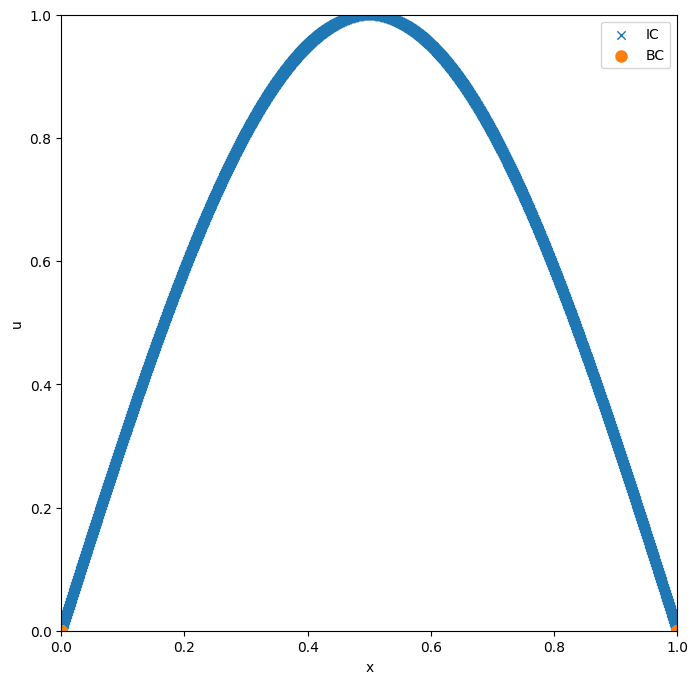

In [4]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=10000, random=False, device="cuda:0")
x, t, u = initial_conditions.get_initial_conditions()
print(x.shape, t.shape, u.shape)

boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=10000, random=False, device="cuda:0")
x, t, u = boundary_conditions.get_boundary_conditions()
print(x.shape, t.shape, u.shape)

pde_heat = pde.PDE('heat', alpha=0.1)

equation = conditions.Equation()
equation.set_equation(pde=pde_heat, geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = equation.get_equation_points()
print(x.shape, t.shape)

test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=10000, random=False, device="cuda:0")
x, t = test.get_test()
print(x.shape, t.shape)

problem = conditions.Problem(initial_conditions, boundary_conditions, 
                             equation, test, geom, period, alpha=0.1)

visualizations.conditions_plot(problem, t=0.0)

In [4]:
# x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
# x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

# TODO: Make comparison with analytical solution
# x_equation = torch.linspace(0, 1, 100)
# t_equation = torch.linspace(0, 0.5, 100)
# x_equation, t_equation = torch.meshgrid(x_equation, t_equation)
# u_equation = analytical_solution(x_equation, t_equation, 0.1, 1)

# x_equation, t_equation, u_equation = fdm_solver(problem=problem, Nx=100)
# solution = conditions.Solution()
# solution.set_solution(x_equation, t_equation, u_equation)

# visualizations.solution_surface_plot(problem, solution)

## Tests

### Common functions

In [5]:
def average_loss(output_path, base_name, out_name):
    loss_data = {}
    for n in range(10):
        file_name = f"{base_name}{n}.csv"
        file_path = os.path.join(output_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    iteration = int(parts[0])
                    loss = float(parts[1])
                    
                    if iteration not in loss_data:
                        loss_data[iteration] = []
                    
                    loss_data[iteration].append(loss)

    average_loss_data = {iteration: np.mean(losses) for iteration, losses in loss_data.items()}
    max_iteration = max(average_loss_data.keys(), default=0)
    new_file_path = os.path.join(output_path, out_name)
    with open(new_file_path, 'w') as new_file:
        for iteration in range(100, max_iteration + 1, 100):
            if iteration in average_loss_data:
                avg_loss = average_loss_data[iteration]
            else:
                avg_loss = average_loss_data[max(average_loss_data.keys(), default=0)]
            
            new_file.write(f"{iteration}, {avg_loss}\n")

In [6]:
def plot_loss(output_path):
    files = os.listdir(output_path)
    scheduler_files = [file for file in files if file.endswith('.csv')]
    schedulers_data = {}

    for file_name in scheduler_files:
        scheduler_name = file_name.split('_')[-1].split('.')[0]
        file_path = os.path.join(output_path, file_name)
        with open(file_path, 'r') as file:
            data = [tuple(map(float, line.strip().split(', '))) for line in file]
            schedulers_data[scheduler_name] = data

    plt.figure(figsize=(15, 10))
    for scheduler_name, data in schedulers_data.items():
        iterations, losses = zip(*data)
        plt.plot(iterations, losses, label=scheduler_name)

    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss for Different Schedulers')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_path, 'scheduler_loss.png'))
    plt.show()

### Scheduler importance test

In [7]:
def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(20) for _ in range(2)],
                            epochs=3000,
                            batch_size=100,
                            lr=0.003,
                            activation='tanh',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=True,
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=None)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

In [ ]:
average_loss('out', 'HL_2_A_Tanh()_N_20_', 'HL_2_A_Tanh()_N_20_avg_scheduler_None.csv')

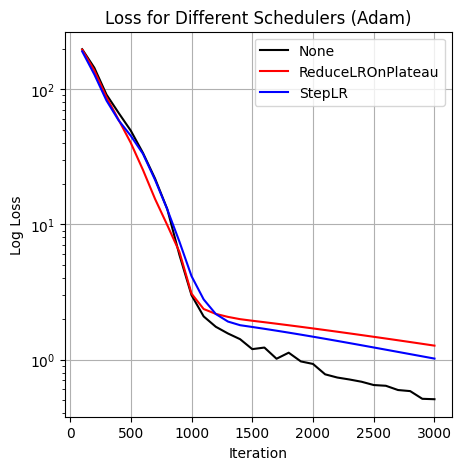

In [ ]:
import os
import pandas as pd

data_adam_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_None.csv'))
data_adam_reduce = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_ReduceLROnPlateau.csv'))
data_adam_step = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_adam/HL_2_A_Tanh()_N_20_avg_scheduler_StepLR.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_adam_none['iteration'], data_adam_none['loss'], label='None', c='black')
plt.plot(data_adam_reduce['iteration'], data_adam_reduce['loss'], label='ReduceLROnPlateau', c='red')
plt.plot(data_adam_step['iteration'], data_adam_step['loss'], label='StepLR', c='blue')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss for Different Schedulers (Adam)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'schedulers', 'scheduler_loss_adam.png'))
plt.show()

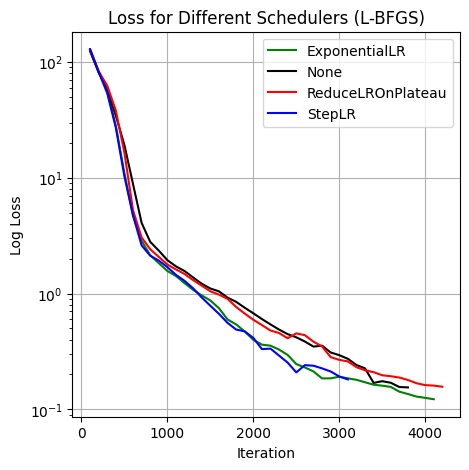

In [ ]:
data_lbfgs_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_None.csv'))
data_lbfgs_reduce = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_ReduceLROnPlateau.csv'))
data_lbfgs_step = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_StepLR.csv'))
data_lbfgs_exp = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/schedulers/20x2_epoch3000_lr0_003_tanh_lbfgs/HL_2_A_Tanh()_N_20_avg_scheduler_ExponentialLR.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_lbfgs_exp['iteration'], data_lbfgs_exp['loss'], label='ExponentialLR', c='green')
plt.plot(data_lbfgs_none['iteration'], data_lbfgs_none['loss'], label='None', c='black')
plt.plot(data_lbfgs_reduce['iteration'], data_lbfgs_reduce['loss'], label='ReduceLROnPlateau', c='red')
plt.plot(data_lbfgs_step['iteration'], data_lbfgs_step['loss'], label='StepLR', c='blue')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss for Different Schedulers (L-BFGS)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'schedulers', 'scheduler_loss_lbfgs.png'))
plt.show()

### Optimizer influence

In [ ]:
def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(20) for _ in range(2)],
                            epochs=3000,
                            batch_size=100,
                            lr=0.003,
                            activation='tanh',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='LBFGS', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=True,
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=None)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

In [ ]:
average_loss('out', 'HL_2_A_Tanh()_N_20_', 'HL_2_A_Tanh()_N_20_avg_optimizer_Adam.csv')

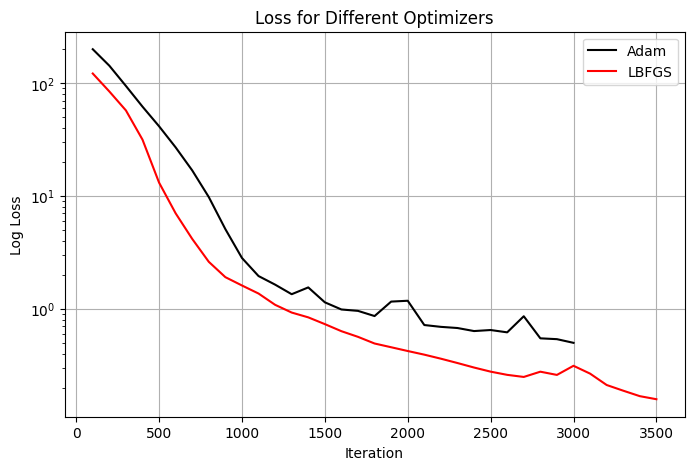

In [ ]:
import os
import pandas as pd

data_adam = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/optimizers/HL_2_A_Tanh()_N_20_avg_optimizer_Adam.csv'))
data_lbfgs = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/optimizers/HL_2_A_Tanh()_N_20_avg_optimizer_LBFGS.csv'))

plt.figure(figsize=(8, 5))
plt.plot(data_adam['iteration'], data_adam['loss'], label='Adam', c='black')
plt.plot(data_lbfgs['iteration'], data_lbfgs['loss'], label='LBFGS', c='red')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss for Different Optimizers')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'optimizers', 'optimizer_loss.png'))
plt.show()

In [ ]:
plot_loss('out')

### WeightAdjuster test

In [ ]:
def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(20) for _ in range(2)],
                            epochs=3000,
                            batch_size=100,
                            lr=0.003,
                            activation='tanh',
                            training_mode='train',
                            regularization='no',
                            lambda_reg=None,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=False,
                            use_rar=False,
                            use_weights_adjuster=True,
                            display_interval=100,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=None)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

Activation Function: Tanh
Hidden Dimensions: 2
Number of neurons: 20
----------
Layer 0: Linear(in_features=2, out_features=20, bias=True) -> Tanh
Layer 1: Linear(in_features=20, out_features=20, bias=True) -> Tanh
Layer 2: Linear(in_features=20, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: Adam
Iteration 100: Loss 0.1081697940826416
Iteration 200: Loss 0.05197549983859062
Iteration 300: Loss 0.009143264964222908
Iteration 400: Loss 0.004332870710641146
Iteration 500: Loss 0.003272532019764185
Iteration 600: Loss 0.005658743903040886
Iteration 700: Loss 0.0035156758967787027
Iteration 800: Loss 0.008379891514778137
Iteration 900: Loss 0.0026200800202786922
Iteration 1000: Loss 0.005729330703616142
Iteration 1100: Loss 0.0022252770140767097
Iteration 1200: Loss 0.005601924378424883
Iteration 1300: Loss 0.007106735371053219
Iteration 1400: Loss 0.005057863891124725
Iteration 1500: Loss 0.003667720127850771
Iteration 1600: Loss 0.008642689324915409
Iteration 1700: Loss

In [ ]:
average_loss('out', 'HL_2_A_Tanh()_N_20_', 'HL_2_A_Tanh()_N_20_avg_weights_adjuster.csv')

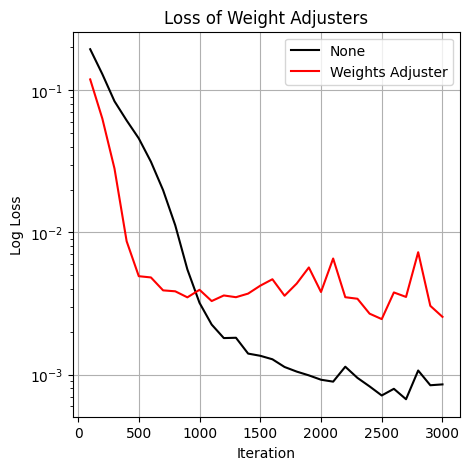

In [ ]:
import os
import pandas as pd

data_none = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/weights_adjuster/HL_2_A_Tanh()_N_20_avg_none.csv'))
data_weights = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/weights_adjuster/HL_2_A_Tanh()_N_20_avg_weights_adjuster.csv'))

plt.figure(figsize=(5, 5))
plt.plot(data_none['iteration'], data_none['loss'], label='None', c='black')
plt.plot(data_weights['iteration'], data_weights['loss'], label='Weights Adjuster', c='red')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss of Weight Adjusters')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'weights_adjuster', 'weights_adjuster_loss.png'))
plt.show()

In [ ]:
plot_loss('out')

### Fine-tuning test 

### RAR

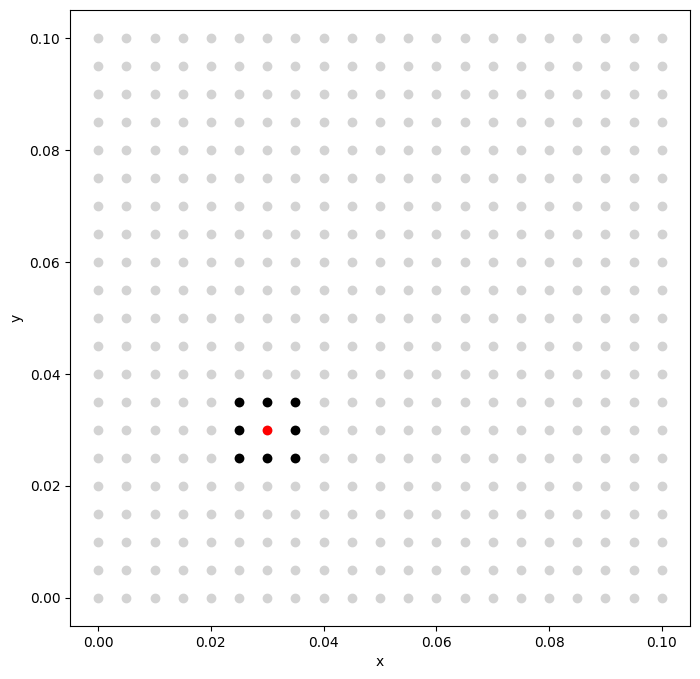

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import numpy as np

x = np.linspace(0, 0.1, 21)
y = np.linspace(0, 0.1, 21)
X, Y = np.meshgrid(x, y)
points = np.c_[X.ravel(), Y.ravel()]
tree = KDTree(points)

plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], c='lightgray')

central_point = (0.03, 0.03)
plt.scatter(central_point[0], central_point[1], c='red')

distances, indices = tree.query(central_point, k=9)
closest_points = points[indices][1:]

for point in closest_points:
    plt.scatter(point[0], point[1], color='black')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

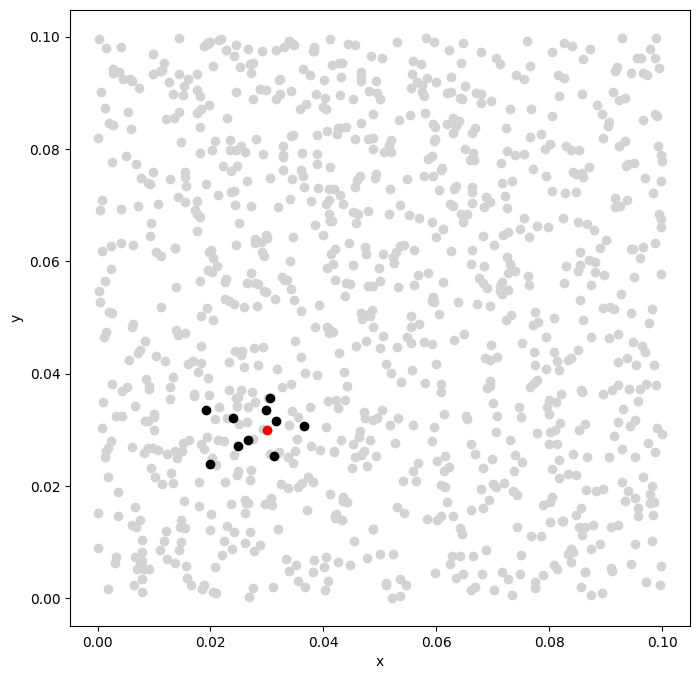

In [ ]:
N = 1000
random_points = np.random.rand(N, 2) * 0.1
tree = KDTree(random_points)
plt.figure(figsize=(8, 8))
plt.scatter(random_points[:, 0], random_points[:, 1], c='lightgray')

central_point = (0.03, 0.03)
plt.scatter(central_point[0], central_point[1], c='red')

epsilon = 0.005
num_points = 10
dimension = len(central_point)
new_points = central_point + np.random.normal(0, epsilon, size=(num_points, dimension))

for point in new_points:
    plt.scatter(point[0], point[1], color='black')

plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Regularization

In [ ]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

def run_training(runs):
    for i in range(runs):
        net_params = utils.NetParams()
        net_params.set_params(input=2,
                            output=1,
                            hidden_layers=[int(8) for _ in range(2)],
                            epochs=5000,
                            batch_size=100,
                            lr=0.0001,
                            activation='sin',
                            training_mode='train',
                            regularization='Elastic', # 'Lasso', 'Ridge', 'Elastic'
                            lambda_reg=0.01,
                            optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                            scheduler=None, # Not applicable with Hybrid optimizer
                            # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                            early_stopping=False, # Some problem
                            use_rar=False,
                            use_weights_adjuster=False,
                            display_interval=50,
                            model_save_path='models',
                            output_path='out',
                            save_loss=True,
                            initial_weights_path=None, # 'models/model_weights.pth'
                            siren_params=siren_params)
        
        model = pinn.PINN(problem, net_params, device='cuda:0')
        model.train()

In [ ]:
run_training(10)

Activation Function: Sin
Hidden Dimensions: 2
Number of neurons: 8
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=8, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=8, out_features=8, bias=True)
) -> Linear
Layer 2: Linear(in_features=8, out_features=1, bias=True)
----------
Next number: 0
Oprtimizer: Adam
Iteration 50: Loss 0.32260459661483765
Iteration 100: Loss 0.3312661945819855
Iteration 150: Loss 0.3307605981826782
Iteration 200: Loss 0.31223493814468384
Iteration 250: Loss 0.27824312448501587
Iteration 300: Loss 0.23609033226966858
Iteration 350: Loss 0.19228984415531158
Iteration 400: Loss 0.15304021537303925
Iteration 450: Loss 0.12223359197378159
Iteration 500: Loss 0.09939199686050415
Iteration 550: Loss 0.082858607172966
Iteration 600: Loss 0.07076231390237808
Iteration 650: Loss 0.061495840549468994
Iteration 700: Loss 0.053946252912282944
Iteration 750: Loss 0.04751173034310341
Iteration 800: Loss 0.0419706255197

In [ ]:
average_loss('out', 'HL_2_A_Sin()_N_8_', 'HL_2_A_Sin()_N_8_avg_regularization_Elastic.csv')

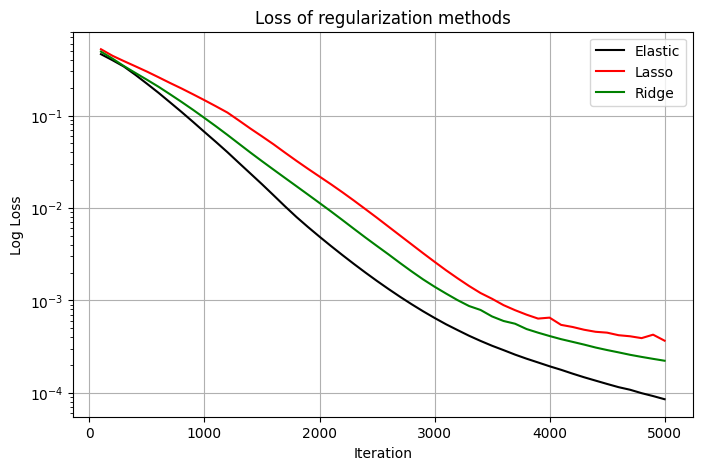

In [ ]:
import os
import pandas as pd

data_elastic = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Elastic.csv'))
data_lasso = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Lasso.csv'))
data_ridge = pd.read_csv(os.path.join(os.getcwd(),'docs/tests/regularizations/HL_2_A_Sin()_N_8_avg_regularization_Ridge.csv'))

plt.figure(figsize=(8, 5))
plt.plot(data_elastic['iteration'], data_elastic['loss'], label='Elastic', c='black')
plt.plot(data_lasso['iteration'], data_lasso['loss'], label='Lasso', c='red')
plt.plot(data_ridge['iteration'], data_ridge['loss'], label='Ridge', c='green')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.yscale('log')
plt.title('Loss of regularization methods')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'regularizations', 'regularization_loss.png'))
plt.show()

## Debug

In [5]:
siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = utils.NetParams()
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(8) for _ in range(2)],
                      epochs=5000,
                      batch_size=100,
                      lr=0.0001,
                      activation='sin',
                      training_mode='train',
                      regularization=None,
                      lambda_reg=None,
                      optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                      scheduler=None, # Not applicable with Hybrid optimizer
                      # 'StepLR', 'ExponentialLR', 'ReduceLROnPlateau' is supported
                      early_stopping=False, # Some problem
                      use_rar=False,
                      use_weights_adjuster=False,
                      display_interval=50,
                      model_save_path='models',
                      output_path='out',
                      save_loss=True,
                      initial_weights_path=None, # 'models/model_weights.pth'
                      siren_params=siren_params)

# TODO: Early stopping not work correctly
# Or load from json file
# net_params.from_json_file("params.json")

In [6]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.training_mode
model.train()
model.save_weights()

1
Activation Function: Sin
Hidden Dimensions: 2
Number of neurons: 8
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=8, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=8, out_features=8, bias=True)
) -> Linear
Layer 2: Linear(in_features=8, out_features=1, bias=True)
----------
Next number: 6
Oprtimizer: Adam
Iteration 50: Loss 0.3461541533470154
Iteration 100: Loss 0.33282268047332764
Iteration 150: Loss 0.3245585560798645
Iteration 200: Loss 0.3207305371761322
Iteration 250: Loss 0.3198869824409485
Iteration 300: Loss 0.32191652059555054
Iteration 350: Loss 0.3185097873210907
Iteration 400: Loss 0.3078776001930237
Iteration 450: Loss 0.2914682626724243
Iteration 500: Loss 0.27174314856529236
Iteration 550: Loss 0.24875569343566895
Iteration 600: Loss 0.2261538952589035
Iteration 650: Loss 0.20560579001903534
Iteration 700: Loss 0.1857927292585373
Iteration 750: Loss 0.16615736484527588
Iteration 800: Loss 0.14751768112182617


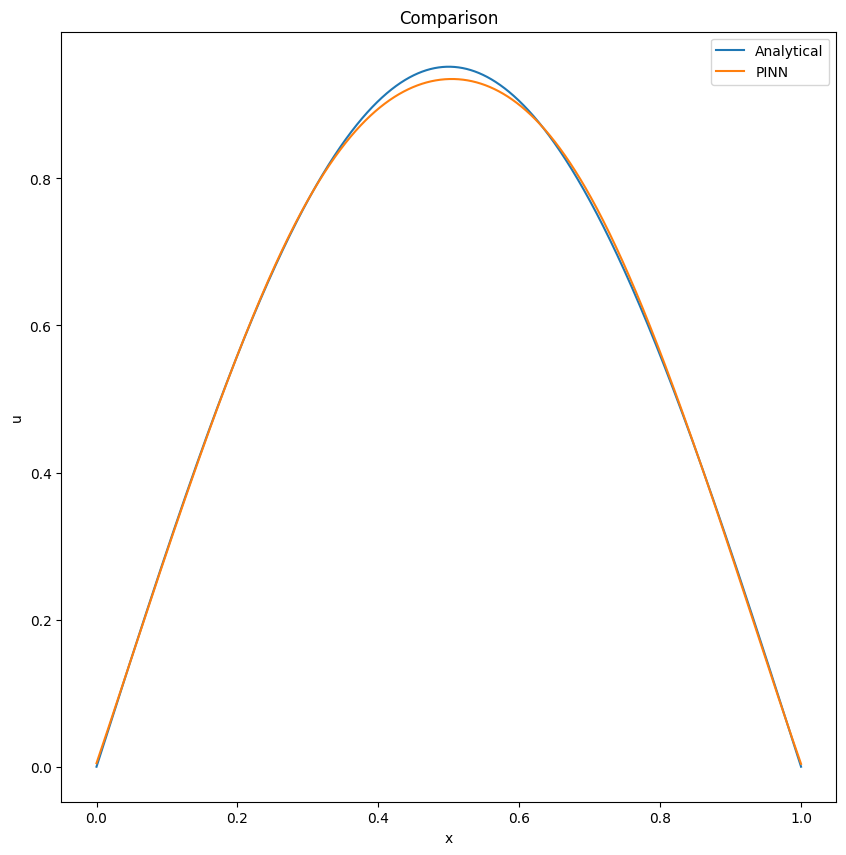

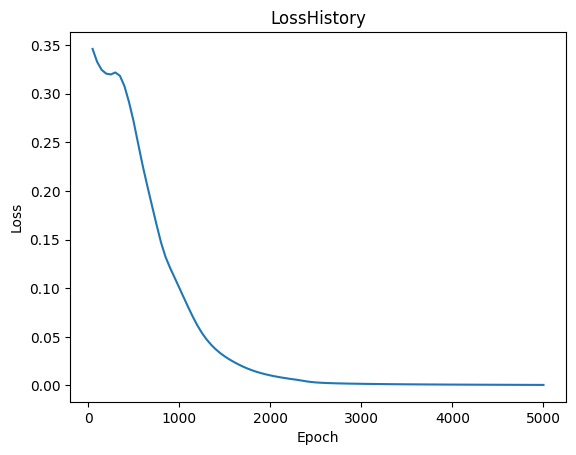

In [7]:
x, t = problem.test.get_test()
u_pinn = model.predict(x, t)

solution_pinn = conditions.Solution()
solution_pinn.set_solution(x, t, u_pinn)

u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                   problem.time.t1, problem.alpha, 
                                   problem.geom.length()).to('cuda:0')
solution_analytical = conditions.Solution()
solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

# Plot of solutions
visualizations.comparison_plot(problem, solution_pinn, solution_analytical, net_params.output_path)

# Plot loss
visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

In [8]:
# L2 norm between analytical and PINN solutions
l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

L2 norm: 0.007060958072543144
